# (SWAG-approximated) Bayesian Neural Network

In [2]:
import jax
import distrax
import optax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from typing import Callable
from tqdm.notebook import tqdm
from functools import partial
from sklearn.metrics import confusion_matrix
from torchvision.datasets import MNIST
from jax.flatten_util import ravel_pytree

2022-08-30 10:28:47.442373: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
root = "/tmp/mnist"
mnist_train = MNIST(root, download=True, train=True)
mnist_test = MNIST(root, download=True, train=False)

In [5]:
class MLP1D(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Dense(10)(x))
        x = nn.relu(nn.Dense(10)(x))
        x = nn.relu(nn.Dense(10)(x))
        x = nn.Dense(10)(x)
        return x

    
class LeNet5(nn.Module):
  num_classes: int
  activation: Callable[[jnp.ndarray], jnp.ndarray] = nn.relu
    
  @nn.compact
  def __call__(self, x):
    x = x if len(x.shape) > 1 else x[None, :]
    x = x.reshape((x.shape[0], 28, 28, 1))
    x = self.activation(nn.Conv(features=6, kernel_size=(5,5), padding="SAME")(x))
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
    x = self.activation(nn.Conv(features=16, kernel_size=(5,5), padding="VALID")(x))
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
    x = x.reshape((x.shape[0], -1))
    x = self.activation(nn.Dense(features=120)(x))
    x = self.activation(nn.Dense(features=84)(x))
    x = nn.Dense(features=self.num_classes)(x)
    x = nn.log_softmax(x)
    return x

class SmallCNN(nn.Module):
    num_classes: int
    activation: Callable[[jnp.ndarray], jnp.ndarray] = nn.relu
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=6, kernel_size=(5, 5), padding="SAME")(x)
        x = self.activation(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=120)(x)
        x = self.activation(x)
        x = nn.Dense(features=84)(x)
        x = self.activation(x)
        x = nn.Dense(features=self.num_classes)(x)
        x = nn.log_softmax(x)
        return x
        

def bnn_log_joint(params, X, y, model):
    flatten_params, _ = ravel_pytree(params)
    logits = model.apply(params, X)
    
    log_prior = distrax.Normal(0.0, 1.0).log_prob(flatten_params).sum()
    log_likelihood = distrax.Multinomial(10, logits=logits).log_prob(y).sum()
    
    log_joint = log_prior + log_likelihood
    return log_joint

def bnn_loss_fn(params, X, y, model): return -bnn_log_joint(params, X, y, model)

In [6]:
key = jax.random.PRNGKey(314)
key_samples, key_init, key_train, key = jax.random.split(key, 4)

In [7]:
X_train = jnp.array(mnist_train.data)
y_train = jnp.array(mnist_train.targets)

n_train, *_ = X_train.shape
# "Gaussanised" MNIST
Xf_train = X_train[..., None]
Xf_train = Xf_train / Xf_train.max()
Xf_train = (Xf_train - Xf_train.mean()) / Xf_train.std()

y_ohe_train = jax.nn.one_hot(y_train, 10)

num_samples = len(Xf_train)

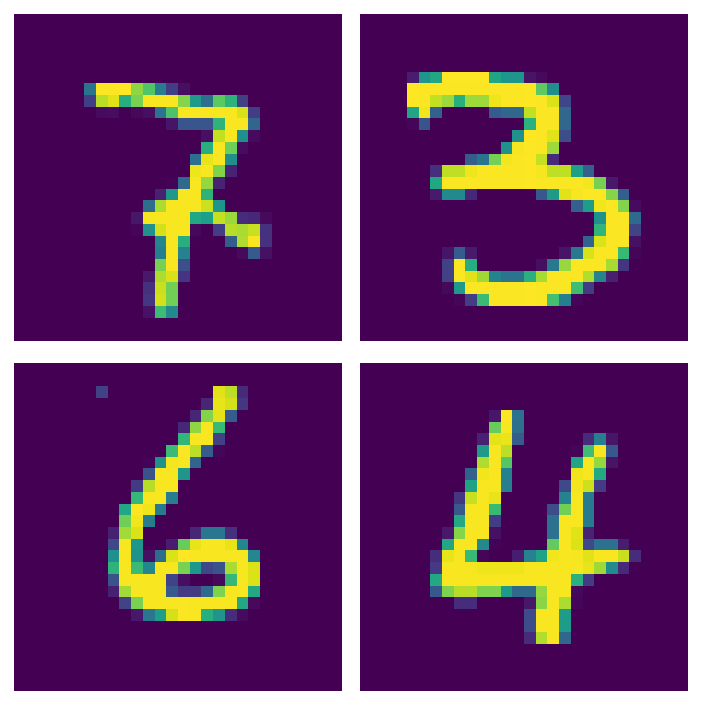

In [8]:
key = jax.random.PRNGKey(314)
key_sample, key = jax.random.split(key)
ixs = jax.random.choice(key, n_train, (4,))

fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs = axs.ravel()
for ix, ax in zip(ixs, axs):
    ax.imshow(Xf_train[ix].reshape(28, 28))
    ax.axis("off")
plt.tight_layout()

In [9]:
@jax.jit
def train_step(params, opt_state, X_batch, y_batch):
    loss_fn = partial(bnn_loss_fn, X=X_batch, y=y_batch, model=model)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    return loss_val, params
    

def get_batch_train_ixs(key, num_samples, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    steps_per_epoch = num_samples // batch_size
    
    batch_ixs = jax.random.permutation(key, num_samples)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    return batch_ixs


def train_epoch_sgd(key, params, opt_step, X, y, batch_size, epoch):
    num_samples = len(X)
    batch_ixs = get_batch_train_ixs(key, num_samples, batch_size)
    
    total_loss = 0
    num_batches = len(batch_ixs)
    
    for batch_ix in batch_ixs:
        X_batch = X[batch_ix, ...]
        y_batch = y[batch_ix, ...]
        loss, params = train_step(params, opt_step, X_batch, y_batch)
        total_loss += loss
    
    mean_loss = total_loss / num_batches
    return params, opt_step, mean_loss

In [10]:
batch_size = 500
num_epochs = 150
learning_rate = 1e-5
tx = optax.adam(learning_rate=learning_rate)

model = SmallCNN(10)

batch = jnp.ones((batch_size, 28, 28, 1))
params = model.init(key_init, batch)
opt_state = tx.init(params)

losses = []

loss_old = jnp.inf
for e in tqdm(range(num_epochs)):
    _, key_train = jax.random.split(key_train)
    params, opt_state, loss = train_epoch_sgd(key_train, params, opt_state,
                                              Xf_train, y_ohe_train, batch_size, e)
    losses.append(loss)
    
    if abs(loss / loss_old - 1) < 1e-7:
        break
    else:
        loss_old = loss

  0%|          | 0/150 [00:00<?, ?it/s]

In [11]:
%%time
yhat_train = model.apply(params, Xf_train).argmax(axis=1)

CPU times: user 8 s, sys: 0 ns, total: 8 s
Wall time: 7.53 s


In [12]:
acc_train = (y_train == yhat_train).mean()
print(f"{acc_train:0.2%}")
confusion_matrix(y_train, yhat_train)

98.05%


array([[5863,    2,    8,    0,    3,    5,   17,    2,   17,    6],
       [   1, 6662,   29,    6,    7,    0,    3,   10,   21,    3],
       [  12,   20, 5834,   12,   11,    0,    8,   29,   27,    5],
       [   5,    8,   33, 5966,    3,   34,    1,   24,   29,   28],
       [   5,   12,   10,    0, 5733,    1,   15,    5,    8,   53],
       [   8,    6,    3,   23,    4, 5308,   29,    3,   23,   14],
       [  15,   10,    2,    0,    9,   22, 5848,    0,   12,    0],
       [   5,   22,   27,    4,   18,    2,    0, 6147,    8,   32],
       [  17,   34,   17,   15,   15,   19,   18,    8, 5690,   18],
       [  14,   15,    2,   18,   44,   13,    2,   46,   17, 5778]])

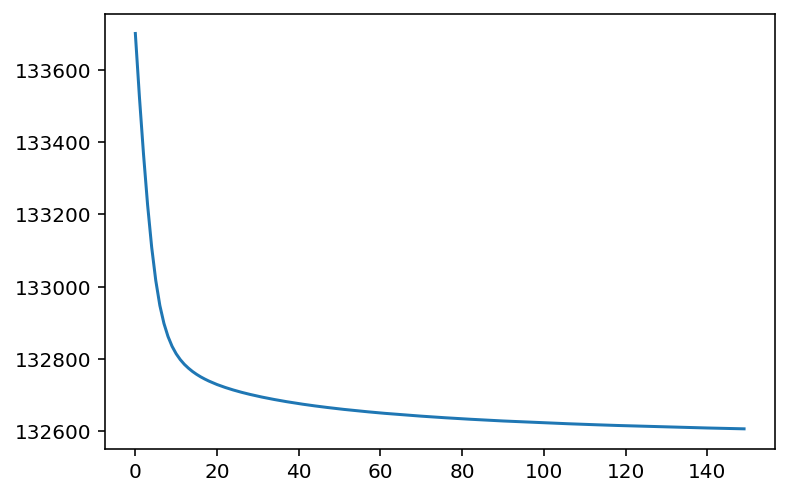

In [13]:
plt.plot(losses)

## Swag

In [14]:
def get_swag_ixs(key, num_samples, batch_size, num_data_passes):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    keys = jax.random.split(key, num_data_passes)
    batches_fn = jax.vmap(get_batch_train_ixs, (0, None, None))
    batches_ix = batches_fn(keys, num_samples, batch_size)
    batches_ix = batches_ix.reshape(-1, batch_size)
    
    return batches_ix


def update_first_moment(moment, params, n):
    moment = jax.tree_map(lambda mean, theta: (n * mean + theta) / (n + 1),
                          moment, params)
    return moment


def update_second_moment(moment, params, n):
    moment = jax.tree_map(lambda mean2, theta: (n * mean2 + theta ** 2) / (n + 1),
                          moment, params)
    return moment


def train_step(params, opt_state, X_batch, y_batch, tx, loss_fn, model):
    loss_fn = partial(loss_fn, X=X_batch, y=y_batch, model=model)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    return loss_val, params

@jax.jit
def insert(storage, index, new_item, capacity):
    storage = storage.at[:, index].set(new_item)
    index = (index + 1) % capacity
    return storage, index

In [15]:
batches_ix = get_swag_ixs(key, num_samples, batch_size, 10)
update_freq = 10
T = len(batches_ix)

In [16]:
T / update_freq

120.0

In [17]:
num_K = 20
learning_rate = 1e-5
tx_swag = optax.sgd(learning_rate=learning_rate)
train_step_part = jax.jit(partial(train_step, tx=tx_swag, loss_fn=bnn_loss_fn, model=model))


# SWAG - moment params
params_moment = params.copy({})
params_moment2 = jax.tree_map(lambda x: x ** 2, params)


params_swag = params.copy({})
opt_state_swag = tx_swag.init(params_swag)

# Initialise difference storage
index = 0
params_flat, *_ = ravel_pytree(params_moment)
num_params, *_ = params_flat.shape
storage = jnp.empty((num_params, num_K))


for t, batch_ix in tqdm(enumerate(batches_ix), total=T):
    X_batch = Xf_train[batch_ix, ...]
    y_batch = y_ohe_train[batch_ix, ...]
    
    loss, params_swag = train_step_part(params_swag, opt_state_swag, X_batch, y_batch)
    
    if t % update_freq == 0:
        n = t // update_freq
        params_moment = update_first_moment(params_moment, params_swag, n)
        params_moment2 = update_second_moment(params_moment2, params_swag, n)
        
        params_diff = jax.tree_map(lambda x, y: x - y, params_swag, params_moment)
        params_diff, *_ = ravel_pytree(params_diff)
        storage, index = insert(storage, index, params_diff, num_K)

  0%|          | 0/1200 [00:00<?, ?it/s]

In [18]:
cpu_device, *_ = jax.devices("cpu")

params_swag = params_moment.copy({})
Sigma_diag = jax.tree_map(lambda w2, w: w2 - w ** 2, params_moment2, params_moment)
Sigma_diag, reconstruct_fn = ravel_pytree(Sigma_diag)

params_swag = jax.device_put(params_swag, cpu_device)
params_swag, _ = ravel_pytree(params_swag)
Sigma_diag = jax.device_put(Sigma_diag, cpu_device) / 2
# Sigma_diag = jnp.diag(Sigma_diag) / 2

In [19]:
storage = jax.device_put(storage, cpu_device)
D = jnp.einsum("nk,mk->nm", storage, storage)
D = D / (2 * num_K - 2)

tcmalloc: large alloc 92915236864 bytes == 0x561109afc000 @  0x7f060e830680 0x7f060e851824 0x7f060e851b8a 0x7f0603f35ff4 0x7f060003692f 0x7f060004230c 0x7f06000459e5 0x7f05fff8f37a 0x7f05ffce9f68 0x7f05ffcce00b 0x56108c826714 0x56108c7f69ef 0x56108c787e19 0x56108c7abfdc 0x56108c834b0d 0x56108c835527 0x56108c731c17 0x56108c7321eb 0x56108c7ea8f8 0x56108c87e740 0x56108c834b0d 0x56108c835527 0x56108c7ea7f7 0x56108c87e740 0x56108c835753 0x56108c7ab10d 0x56108c8348e2 0x56108c835527 0x56108c7ea7f7 0x56108c87e740 0x56108c8610ed
tcmalloc: large alloc 92915236864 bytes == 0x5626b40f0000 @  0x7f060e830680 0x7f060e851824 0x7f060e851b8a 0x7f0603f35ff4 0x7f060003692f 0x7f060004230c 0x7f06000459e5 0x7f05fff8f37a 0x7f05ffce9f68 0x7f05ffcce00b 0x56108c826714 0x56108c7f69ef 0x56108c787e19 0x56108c7abfdc 0x56108c834b0d 0x56108c835527 0x56108c731c17 0x56108c7321eb 0x56108c7ea8f8 0x56108c87e740 0x56108c834b0d 0x56108c835527 0x56108c7ea7f7 0x56108c87e740 0x56108c835753 0x56108c7ab10d 0x56108c8348e2 0x56108c

In [20]:
num_posterior_samples = 10_000

In [22]:
num_params

152410

In [ ]:
full_covariance = D.at[jnp.arange(num_params), jnp.arange(num_params)].set(Sigma_diag)

tcmalloc: large alloc 92915236864 bytes == 0x561109afc000 @  0x7f060e830680 0x7f060e851824 0x7f060e851b8a 0x7f0603f35ff4 0x7f060003692f 0x7f060004230c 0x7f06000459e5 0x7f05fff8f37a 0x7f05ffce9f68 0x7f05ffcce00b 0x56108c826714 0x56108c7f69ef 0x56108c787e19 0x56108c7abfdc 0x56108c834b0d 0x56108c835527 0x56108c731c17 0x56108c7321eb 0x56108c7ea8f8 0x56108c87e740 0x56108c834b0d 0x56108c835527 0x56108c7ea8f8 0x56108c87e740 0x56108c8348e2 0x56108c835527 0x56108c731c17 0x56108c8bb592 0x56108c7ea7f7 0x56108c87e740 0x56108c835753


In [ ]:
posterior_samples = jax.random.multivariate_normal(key, params_swag, full_covariance, (num_posterior_samples,))

tcmalloc: large alloc 6096404480 bytes == 0x563c5b3d0000 @  0x7f060e830680 0x7f060e851824 0x7f060e851b8a 0x7f0603f35ff4 0x7f060003692f 0x7f060004230c 0x7f06000459e5 0x7f05fff8f37a 0x7f05ffce9f68 0x7f05ffcce00b 0x56108c826714 0x56108c7f69ef 0x56108c787e19 0x56108c7abfdc 0x56108c834b0d 0x56108c835527 0x56108c731c17 0x56108c7321eb 0x56108c7ea8f8 0x56108c87e740 0x56108c834b0d 0x56108c835527 0x56108c7ea7f7 0x56108c87e740 0x56108c835753 0x56108c7ab10d 0x56108c8348e2 0x56108c835527 0x56108c7ea7f7 0x56108c87e740 0x56108c8610ed
tcmalloc: large alloc 185830465536 bytes == 0x563dc71cc000 @  0x7f060e830680 0x7f060e851824 0x7f060e851b8a 0x7f0603f35ff4 0x7f060003692f 0x7f060004230c 0x7f06000459e5 0x7f05fff8f37a 0x7f05ffce9f68 0x7f05ffcce00b 0x56108c826714 0x56108c7f69ef 0x56108c787e19 0x56108c7abfdc 0x56108c834b0d 0x56108c835527 0x56108c731c17 0x56108c7321eb 0x56108c7ea8f8 0x56108c87e740 0x56108c834b0d 0x56108c835527 0x56108c7ea7f7 0x56108c87e740 0x56108c835753 0x56108c7ab10d 0x56108c8348e2 0x56108c

In [ ]:
posterior_samples.shape